# <center>Wasserstein GAN</center>

In [1]:
import torch
import tqdm
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}.')

Device: mps.


## Datos de entrenamiento

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
    ])

dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## GAN

### Red generadora

In [3]:
class Generator(nn.Module):
    def __init__(self, output_shape, hidden_dim=100):
        super().__init__()

        self.output_shape = output_shape
        self.hidden_dim = hidden_dim

        channels, height, width = output_shape

        self.layer = nn.Sequential(
            nn.Linear(hidden_dim, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 256), nn.BatchNorm1d(256), nn.LeakyReLU(0.2),
            nn.Linear(256, 512), nn.BatchNorm1d(512), nn.LeakyReLU(0.2),
            nn.Linear(512, 1024), nn.BatchNorm1d(1024), nn.LeakyReLU(0.2),
            nn.Linear(1024, channels * height * width), nn.Tanh()
        )

    def forward(self, x):
        batch_size = len(x)
        x = self.layer(x)
        return x.view(batch_size, *self.output_shape)

### Red discriminadora

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        channels, height, width = input_shape

        self.layer = nn.Sequential(
            nn.Linear(channels * height * width, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = nn.Flatten()(x)
        return self.layer(x)

### Entrenamiento

In [5]:
def train_gan(generator, discriminator, dataloader, epochs, lr=0.00005, n_critic=5, clip_value=0.01):

    generator.to(device)
    discriminator.to(device)

    # Optimizadores:
    generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=lr)
    discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

    try:
        progressbar = tqdm.trange(epochs)
        for epoch in progressbar:

            epoch_discriminator_loss = 0
            epoch_generator_loss = 0

            for x_true, _ in dataloader:

                batch_size = x_true.size(0)

                # ---------- Entrenamiento discriminador ----------

                for _ in range(n_critic):

                    # Datos reales:
                    x_true = x_true.to(device)
                    x_true_pred = discriminator(x_true)
                    x_true_loss = - torch.mean(x_true_pred)

                    # Datos sintéticos:
                    z = torch.randn(batch_size, generator.hidden_dim, device=device)
                    x_fake = generator(z).detach()
                    x_fake_pred = discriminator(x_fake)
                    x_fake_loss = torch.mean(x_fake_pred)

                    discriminator_loss = x_true_loss + x_fake_loss
                    epoch_discriminator_loss += discriminator_loss.item()
                    discriminator_optimizer.zero_grad()
                    discriminator_loss.backward()
                    discriminator_optimizer.step()

                    # Clip a los parámetros:
                    for param in discriminator.parameters():
                        param.data.clamp_(-clip_value, clip_value)

                # ---------- Entrenamiento generador ----------

                # Datos sintéticos:
                z = torch.randn(batch_size, generator.hidden_dim, device=device)
                x_fake = generator(z)
                x_fake_pred = discriminator(x_fake)
                generator_loss = -torch.mean(x_fake_pred)

                epoch_generator_loss += generator_loss.item()
                generator_optimizer.zero_grad()
                generator_loss.backward()
                generator_optimizer.step()

            epoch_discriminator_loss /= len(dataloader) * n_critic
            epoch_generator_loss /= len(dataloader)
            progressbar.set_postfix(D_loss=epoch_discriminator_loss, G_loss=epoch_generator_loss)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

In [6]:
# Tamaño de entrada y salida:
image_shape = dataset[0][0].shape

# Redes generadora y discriminadora:
generator = Generator(image_shape)
discriminator = Discriminator(image_shape)

# Entrenamiento:
train_gan(generator, discriminator, dataloader, epochs=50)

100%|█████████████| 50/50 [09:02<00:00, 10.85s/it, D_loss=-0.0138, G_loss=-0.71]


### Generación de muestras

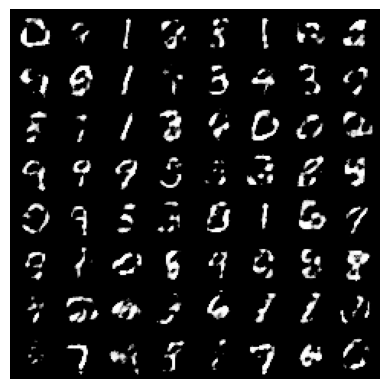

In [8]:
def generate_images(generator, filename, n_samples=64):

    generator.eval()
    z = torch.randn(n_samples, generator.hidden_dim).to(device)

    with torch.no_grad():
        samples = generator(z).cpu()
        samples = make_grid(samples).permute(1,2,0)

    plt.imshow(samples.clip(0,1), cmap='gray')
    plt.axis('off')
    plt.savefig(f'../img/{filename}.pdf', bbox_inches='tight')
    plt.show()

generate_images(generator, filename='wgan_mnist')